In [7]:
import pandas as pd
#import tweepy
import json
import MeCab
from collections import Counter
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import re
import codecs
from datetime import timedelta

In [314]:
#pip list
#5355/200

26.775

In [61]:
access_token = 
access_token_secret = 
consumer_key = 
consumer_key_secret = 

#twitterAPIのためのconfigファイル
#JSON_LOAD_FILE = r"./json/twitter.json"
#twitterからデータを抽出するときの検索ワード
search_word = "野菜"
#twitterからデータを抽出するときの取得件数
SEARCH_COUNT = 100

#tweeterAPIと繋げるAPIインスタンスを生成する
def twitter_api_connect():
    #twiteerのAPIを利用するためのキーを取得


    #twiteerのAPIを利用するための、認証データ作成
    auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
    auth.set_access_token(access_token,access_token_secret)

    #twitterのAPIインスタンス生成
    twitter_api = tweepy.API(auth, wait_on_rate_limit = True)
    return twitter_api

#tweetのデータを取得し、リスト化し、返却する
def tweet_list_create(twitter_api, search_word, search_count):
    #カーソルを使用してデータ取得
    search_tweets = twitter_api.search_users(q = search_word, count = search_count,lang="ja")

    #tweetの内容を格納するためのリスト変数
    search_tweet_list = []

    #取得したtweetの内容をリストに格納
    for search_tweet in search_tweets:
        #print(search_tweets)
        search_tweet_list.append(search_tweet.description) 
    return search_tweet_list



#twitterのAPIインスタンス生成
api = twitter_api_connect()

#twitterからデータを取得
tweet_list = tweet_list_create(api, search_word , SEARCH_COUNT)
tweet_list

Unexpected parameter: lang


['🐷温野菜公式アカウント🐮美味しい感想や温野菜への熱い思い！お待ちしてます˚✧ぜひタグ付けで教えてください✧༚  DM・コメントの返信は控えさせていただいております🙇\u200d♂️',
 '八百屋歴10年｜ツイート紹介記事がYahooニュースアクセスランキング１位獲得｜本の出版に向けて準備中｜お仕事依頼はDMまで｜毎週末に翌週の相場予報ツイート｜フォローすれば「あっ野菜高くなってる！昨日買っておけば‥ぐぬぬ」という後悔がなくなりますよ。',
 '石川県のソウルフード「とり野菜みそ」でおなじみの株式会社まつや公式Twitter。\n ＃まつやとり野菜みそ でツイートお願いします！！\n ファンネームは #とりっこ\n #北陸Twitter会 ＃公式つぶやき部 #栄光ブラザーズ',
 'フリーで声優の仕事をしています。 引きこもりなのでたまに外に出ると歩き方がおぼつきません。 ▼出没頻度SSRですが生きています。',
 '農家の八代目。農民の傍ら、たまに野菜ソムリエコッシーをやってたりする人。自称「大自然に囲まれた引きこもり」。糸井重里さん @itoi_shigesato 認定エア農家。アイコンの写真は写真家の藤代 冥砂さん\u3000@meisafujishiro に撮影して頂いたものという果報者。 http://t.co/cCmVOOmCXY',
 '野菜で健康になる秘訣を毎朝6時にお届け｜バズツイートがyahoo!ニュース1位掲載、毎日新聞掲載｜農家歴8年｜従業員70名｜470棟のビニールハウスで育てる野菜をツイートで紹介｜社員応募はDM下さい｜▶︎ キャベツは芯をくり抜き濡れたキッチンペーパーを詰め込み、新聞紙を濡らして包んで保存すると長持ちするよ！',
 '30万人に野菜の感動を伝えた野菜三昧の人👨\u200d🌾 13年前にレストラン【農家の台所】で野菜の美味しさに感動→更に翌日持病のアトピーが改善して衝撃→すぐに入社→しかしレストラン向かなくて愕然→野菜セミナーや出張サラダバーなど自分の道へ→コロナの危機から社長へ😋 早大卒🍆Google検索｢出張サラダバー｣1位',
 '音楽座ミュージカル・賢プロダクション所属 | ファーストアルバム「プリズム」：https://t.co/yCVuRf3Q6a',
 '新人声優🎤夏野菜緒です。長崎県対馬産🐟 ✨『アニマ

In [446]:

#アカウント指定(@の後ろの英数字、↓はサンプルID)
Account = 'SuB_AcounTsmart'

#ツイート保存用変数&取得するツイートを計算する
tweet_data = []
num = 0

for page in range(17):
    tweets = api.user_timeline(screen_name=Account, count=200, page=page)
    for tweet in tweets:
        tweet.created_at += timedelta(hours=9)
#         print('----------') #見やすいように
#         print(tweet.created_at) #書くツイートの投稿時間表示
#         print(tweet.text) #各ツイート内容表示
        num += 1
        tweet_data.append(['@'+Account, tweet.created_at, tweet.text])

print(num, 'ツイート表示しました。')

# ツイートデータをデータフレームに変換
tweet_data = pd.DataFrame(tweet_data, columns=["account", "date", "tweet"])


Unexpected parameter: page
Unexpected parameter: page
Unexpected parameter: page
Unexpected parameter: page
Unexpected parameter: page
Unexpected parameter: page
Unexpected parameter: page
Unexpected parameter: page
Unexpected parameter: page
Unexpected parameter: page
Unexpected parameter: page
Unexpected parameter: page
Unexpected parameter: page
Unexpected parameter: page
Unexpected parameter: page
Unexpected parameter: page
Unexpected parameter: page


3141 ツイート表示しました。


In [152]:
import pandas as pd

# 極性辞書をデータフレームで読み込み
df_dic = pd.read_csv('pn_ja.dic', sep=':', names=("Word", "読み", "品詞", "Score"), encoding='shift-jis')

keys = df_dic["Word"].tolist()
values = df_dic["Score"].tolist()
dic = dict(zip(keys, values))
dic

{'優れる': 1.0,
 '良い': 0.999995,
 '喜ぶ': 0.999979,
 '褒める': 0.999979,
 'めでたい': 0.999645,
 '賢い': 0.999486,
 '善い': 0.999314,
 '適す': 0.999295,
 '天晴': 0.999267,
 '祝う': 0.999122,
 '功績': 0.999104,
 '賞': 0.998943,
 '嬉しい': 0.998871,
 '喜び': 0.998861,
 '才知': 0.998771,
 '徳': 0.998745,
 '才能': 0.998699,
 '素晴らしい': 0.998617,
 '芳しい': 0.998578,
 '称える': 0.998576,
 '適切': 0.998406,
 '崇める': 0.998357,
 '助ける': 0.990702,
 '抜きんでる': 0.998356,
 '清水': 0.98213,
 '雄雄しい': 0.998272,
 '仕合せ': 0.998208,
 '幸い': 0.997862,
 '吉兆': 0.997795,
 '秀でる': 0.997777,
 '宜しい': 0.997517,
 'きりりしゃんと': 0.997511,
 '矜持': 0.988946,
 '香しい': 0.997438,
 'しこなす': 0.997408,
 '遣りこなす': 0.997406,
 '優麗': 0.997337,
 '気高い': 0.997325,
 '手柄': 0.997308,
 '正義': 0.997278,
 '麗しい': 0.99726,
 '名高い': 0.997259,
 '感心': 0.997201,
 '誉れ': 0.997198,
 '卓説': 0.997194,
 '巍然': 0.997192,
 '崇敬': 0.997192,
 '美徳': 0.997143,
 '素早い': 0.997105,
 '背負ってる': 0.997074,
 '人材': 0.997049,
 '果報者': 0.997027,
 '多祥': 0.997027,
 '勇ましい': 0.996987,
 '秀逸': 0.996946,
 'まぐれ幸い': 0.996941,
 '賞揚': 0.9969

In [153]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])
print(stopwords)

#####joblibで保存して使いたい時     
import joblib
joblib.dump(stopwords, 'stopwords.jb', compress = 3)
#####

['あそこ', 'あたり', 'あちら', 'あっち', 'あと', 'あな', 'あなた', 'あれ', 'いくつ', 'いつ', 'いま', 'いや', 'いろいろ', 'うち', 'おおまか', 'おまえ', 'おれ', 'がい', 'かく', 'かたち', 'かやの', 'から', 'がら', 'きた', 'くせ', 'ここ', 'こっち', 'こと', 'ごと', 'こちら', 'ごっちゃ', 'これ', 'これら', 'ごろ', 'さまざま', 'さらい', 'さん', 'しかた', 'しよう', 'すか', 'ずつ', 'すね', 'すべて', 'ぜんぶ', 'そう', 'そこ', 'そちら', 'そっち', 'そで', 'それ', 'それぞれ', 'それなり', 'たくさん', 'たち', 'たび', 'ため', 'だめ', 'ちゃ', 'ちゃん', 'てん', 'とおり', 'とき', 'どこ', 'どこか', 'ところ', 'どちら', 'どっか', 'どっち', 'どれ', 'なか', 'なかば', 'なに', 'など', 'なん', 'はじめ', 'はず', 'はるか', 'ひと', 'ひとつ', 'ふく', 'ぶり', 'べつ', 'へん', 'ぺん', 'ほう', 'ほか', 'まさ', 'まし', 'まとも', 'まま', 'みたい', 'みつ', 'みなさん', 'みんな', 'もと', 'もの', 'もん', 'やつ', 'よう', 'よそ', 'わけ', 'わたし', 'ハイ', '上', '中', '下', '字', '年', '月', '日', '時', '分', '秒', '週', '火', '水', '木', '金', '土', '国', '都', '道', '府', '県', '市', '区', '町', '村', '各', '第', '方', '何', '的', '度', '文', '者', '性', '体', '人', '他', '今', '部', '課', '係', '外', '類', '達', '気', '室', '口', '誰', '用', '界', '会', '首', '男', '女', '別', '話', '私', '屋', '店', '家', '場', '等', '見', '際', '観', '段', '

['stopwords.jb']

In [154]:
import joblib
stopwords = joblib.load('stopwords.jb')
stopwords

['あそこ',
 'あたり',
 'あちら',
 'あっち',
 'あと',
 'あな',
 'あなた',
 'あれ',
 'いくつ',
 'いつ',
 'いま',
 'いや',
 'いろいろ',
 'うち',
 'おおまか',
 'おまえ',
 'おれ',
 'がい',
 'かく',
 'かたち',
 'かやの',
 'から',
 'がら',
 'きた',
 'くせ',
 'ここ',
 'こっち',
 'こと',
 'ごと',
 'こちら',
 'ごっちゃ',
 'これ',
 'これら',
 'ごろ',
 'さまざま',
 'さらい',
 'さん',
 'しかた',
 'しよう',
 'すか',
 'ずつ',
 'すね',
 'すべて',
 'ぜんぶ',
 'そう',
 'そこ',
 'そちら',
 'そっち',
 'そで',
 'それ',
 'それぞれ',
 'それなり',
 'たくさん',
 'たち',
 'たび',
 'ため',
 'だめ',
 'ちゃ',
 'ちゃん',
 'てん',
 'とおり',
 'とき',
 'どこ',
 'どこか',
 'ところ',
 'どちら',
 'どっか',
 'どっち',
 'どれ',
 'なか',
 'なかば',
 'なに',
 'など',
 'なん',
 'はじめ',
 'はず',
 'はるか',
 'ひと',
 'ひとつ',
 'ふく',
 'ぶり',
 'べつ',
 'へん',
 'ぺん',
 'ほう',
 'ほか',
 'まさ',
 'まし',
 'まとも',
 'まま',
 'みたい',
 'みつ',
 'みなさん',
 'みんな',
 'もと',
 'もの',
 'もん',
 'やつ',
 'よう',
 'よそ',
 'わけ',
 'わたし',
 'ハイ',
 '上',
 '中',
 '下',
 '字',
 '年',
 '月',
 '日',
 '時',
 '分',
 '秒',
 '週',
 '火',
 '水',
 '木',
 '金',
 '土',
 '国',
 '都',
 '道',
 '府',
 '県',
 '市',
 '区',
 '町',
 '村',
 '各',
 '第',
 '方',
 '何',
 '的',
 '度',
 '文',
 '者',
 '性',
 '体',
 '人',
 '他',
 '今',
 

In [447]:
from janome.tokenizer import Tokenizer
from janome.analyzer import Analyzer
from janome.charfilter import *
from janome.tokenfilter import *

t = Tokenizer()
tweet_list = []

for tweet in tweet_data['tweet']:
    # 複合名詞を抽出
    a = Analyzer(token_filters=[CompoundNounFilter()])
    #result = [token.base_form for token in a.analyze(tweet) if token.part_of_speech.split(',')[0] in ['名詞']]
    # 動詞と形容詞を抽出
    result = [token.base_form for token in t.tokenize(tweet)
       if token.part_of_speech.split(',')[0] in ['動詞']]
    
    result.extend(result2)
    result_list = [tweet, result]
    tweet_list.append(result_list)
tweets = tweet_list.copy()

In [448]:
for tweet in tweet_list:
    for stopword in stopwords:
        tweet[1] = [i for i in tweet[1] if i != stopword]
    tweet_word_num = len(tweet[1])
    tweet.append(tweet_word_num)
    # 辞書で判定
    results = []
    for sentence in tweet[1]:
        word_score = []
        score = dic.get(sentence)
        word_score = (sentence, score)
        results.append(word_score)

    # 判定を追加
    tweet.append(results) 
    # 曲のスコアを2パターンで判定。「Noneを含むパターン」と「Noneを含まないパターン」
    score = 0
    score1 = 0
    score2 = 0
    for word in tweet[3]:
        if word[1] != None:
            score += word[1]
    cnt = sum(not (i[1] == None) for i in tweet[3])  # Noneを含まない形態素数
    if score != 0:
        score1 = score / tweet[2]  # スコアの合計 / 全形態素数
        score2 = score / cnt  # スコアの合計 / Noneを含まない形態素数
    # スコアを追加
    tweet.append(cnt)
    tweet.append(score1)
    tweet.append(score2)

In [449]:
tubu = []
score_list = []
score_list2 = []

for i in range(len(tweet_list)):
    tubu.append(tweet_list[i][0])
    score_list.append(tweet_list[i][5])
    score_list2.append(tweet_list[i][6])

In [450]:
#辞書に無い単語は無かったものとしてスコアを算出する（スコア1）
#辞書に無い単語はスコア 0 として算出する（スコア2）

np_df = pd.DataFrame(tubu)
np_df[1] = score_list
np_df[2] = score_list2
np_df.columns = ['text','score','score2']
np_df

,text,score,score2
0,こんなにほしいものをくれるのはほんまに,0.000000,0.000000
1,ささる,0.000000,0.000000
2,消えればいい,-0.386955,-0.386955
3,こうなんだ,0.000000,0.000000
4,いつも,0.000000,0.000000
...,...,...,...
3136,自殺者を止めるために自分の人生あげられるのかな,-0.318483,-0.955448
3137,自分の気持ちをアウトプット、整理,0.000000,0.000000
3138,俺もこれくらいの覚悟あるはずなんだよな、本当にできるかな,0.000000,0.000000
3139,晴天を穿つ、最高,-0.574004,-0.574004


In [452]:
np_df = np_df[np_df['score'] != 0].reset_index(drop=True)
np_df

,text,score,score2
0,消えればいい,-0.386955,-0.386955
1,全てを置いてしばらく消え去りたい,-0.489914,-0.979829
2,人のこと気遣ってるふりして結局は自分の行動原理がすべてにおいて優先されている\n\n自分の思...,-0.261929,-0.960408
3,こんなアカウントで呟くのもアホらしくなってきた,-0.263409,-0.790228
4,俺たちはお互いを傷つけながらお互いを支え合って生きてる,-0.180535,-0.225669
...,...,...,...
1306,俺の時間を奪わないで、俺を壊さないで,-0.914903,-0.914903
1307,世間の目を気にするわけじゃないけど大変なのは嫌でも分かるよね、そんなこと嫁に押し付けたくないやろ,-0.254864,-0.764592
1308,なんか未成年結婚が云々騒がれてる\n若いうちに結婚するってこういうことなんだな,-0.238510,-0.954041
1309,自殺者を止めるために自分の人生あげられるのかな,-0.318483,-0.955448


In [475]:
np_df['score'].mean(),np_df['score2'].mean()

(-0.35071029209669696, -0.6160835735884982)

In [469]:
word_list = []
for i in range(len(np_df)):
    word_list.extend(tweet_list[i][1])
word_list

['くれる',
 'ささる',
 '消える',
 '置く',
 '消え去る',
 '気遣う',
 'てる',
 'する',
 'する',
 'れる',
 'いる',
 '思う',
 'する',
 'てる',
 '思い込む',
 'する',
 '刺す',
 'れる',
 '呟く',
 'なる',
 'くる',
 '傷つける',
 '支える',
 '合う',
 '生きる',
 'てる',
 '繰り返す',
 'いく',
 '持つ',
 'なる',
 'てる',
 'する',
 'わかる',
 'いる',
 'こたえる',
 'いる',
 'ある',
 '求める',
 'てる',
 'する',
 'やる',
 'できる',
 '行く',
 '飲む',
 '断れる',
 'する',
 'てる',
 '死ぬ',
 '得る',
 'する',
 '捨てる',
 'なる',
 'できる',
 '向き合う',
 'いく',
 '考える',
 '出来る',
 'なおる',
 'する',
 '病む',
 '終わる',
 'する',
 '帰る',
 '捨てる',
 '諦める',
 'てる',
 'する',
 'なる',
 '思う',
 'やる',
 'わかる',
 '知る',
 'てる',
 'する',
 'えむ',
 '苦しむ',
 '逃げる',
 'する',
 '逃げる',
 'られる',
 '出来る',
 '苦しむ',
 '続ける',
 'いる',
 '生きる',
 'いる',
 '言う',
 '耐える',
 '耐える',
 '繰り返す',
 'なる',
 'いく',
 '逃げる',
 '死ぬ',
 '放り出す',
 'できる',
 'なる',
 'いう',
 'ちゃう',
 '居座る',
 'する',
 'する',
 'すぎる',
 '死ぬ',
 '病む',
 'でる',
 'する',
 'てる',
 '死ぬ',
 'なる',
 'やめる',
 '言う',
 'かけ離れる',
 'なる',
 'ちゃう',
 'わかる',
 'する',
 'する',
 'する',
 'いく',
 '出る',
 'くる',
 '分かる',
 'する',
 'てる',
 '変わる',
 'しれる',
 'つく',
 '守る',
 'する',
 '吐く',
 'れる',
 '傷つける',
 'なる',
 

In [470]:
word_list = [re.sub('@.*', '', s) for s in word_list]
word_list = [re.sub('https.*', '', s) for s in word_list]

In [471]:
a = Counter(word_list)
a.most_common()

[('する', 321),
 ('てる', 187),
 ('なる', 133),
 ('いる', 90),
 ('言う', 64),
 ('れる', 63),
 ('できる', 60),
 ('られる', 58),
 ('別れる', 58),
 ('思う', 49),
 ('ある', 46),
 ('やる', 42),
 ('くれる', 39),
 ('すぎる', 39),
 ('しまう', 38),
 ('付き合う', 37),
 ('考える', 32),
 ('いく', 31),
 ('死ぬ', 29),
 ('会う', 27),
 ('くる', 25),
 ('わかる', 24),
 ('生きる', 22),
 ('終わる', 19),
 ('知る', 19),
 ('ちゃう', 19),
 ('見る', 19),
 ('行く', 17),
 ('でる', 16),
 ('出る', 15),
 ('せる', 14),
 ('傷つける', 12),
 ('分かる', 12),
 ('つく', 12),
 ('使う', 12),
 ('みる', 12),
 ('しれる', 11),
 ('受け入れる', 11),
 ('続ける', 10),
 ('いう', 10),
 ('やめる', 10),
 ('頑張る', 10),
 ('感じる', 10),
 ('変える', 10),
 ('繰り返す', 9),
 ('捨てる', 9),
 ('出来る', 9),
 ('苦しむ', 9),
 ('逃げる', 9),
 ('変わる', 9),
 ('話す', 9),
 ('なくなる', 9),
 ('なれる', 9),
 ('忘れる', 9),
 ('寝る', 9),
 ('持つ', 8),
 ('求める', 8),
 ('帰る', 8),
 ('いける', 8),
 ('あげる', 8),
 ('選ぶ', 8),
 ('もらう', 8),
 ('狂う', 8),
 ('決まる', 7),
 ('かける', 6),
 ('わく', 6),
 ('来る', 6),
 ('泣く', 6),
 ('置く', 5),
 ('病む', 5),
 ('えむ', 5),
 ('耐える', 5),
 ('つける', 5),
 ('思い出す', 5),
 ('現れる', 5),
 ('飲む'

In [472]:
s_list = ['する','ん','てる','の','なる','いる','ある','言う','ない','いい','られる','しまう','','ー','w','(',')','`)','☺']

word_stoped_list =[w for w in word_list if w not in s_list]
word_stoped_list

['くれる',
 'ささる',
 '消える',
 '置く',
 '消え去る',
 '気遣う',
 'れる',
 '思う',
 '思い込む',
 '刺す',
 'れる',
 '呟く',
 'くる',
 '傷つける',
 '支える',
 '合う',
 '生きる',
 '繰り返す',
 'いく',
 '持つ',
 'わかる',
 'こたえる',
 '求める',
 'やる',
 'できる',
 '行く',
 '飲む',
 '断れる',
 '死ぬ',
 '得る',
 '捨てる',
 'できる',
 '向き合う',
 'いく',
 '考える',
 '出来る',
 'なおる',
 '病む',
 '終わる',
 '帰る',
 '捨てる',
 '諦める',
 '思う',
 'やる',
 'わかる',
 '知る',
 'えむ',
 '苦しむ',
 '逃げる',
 '逃げる',
 '出来る',
 '苦しむ',
 '続ける',
 '生きる',
 '耐える',
 '耐える',
 '繰り返す',
 'いく',
 '逃げる',
 '死ぬ',
 '放り出す',
 'できる',
 'いう',
 'ちゃう',
 '居座る',
 'すぎる',
 '死ぬ',
 '病む',
 'でる',
 '死ぬ',
 'やめる',
 'かけ離れる',
 'ちゃう',
 'わかる',
 'いく',
 '出る',
 'くる',
 '分かる',
 '変わる',
 'しれる',
 'つく',
 '守る',
 '吐く',
 'れる',
 '傷つける',
 'くれる',
 '思う',
 'くれる',
 '吐き出す',
 'つく',
 'できる',
 '使う',
 'わかる',
 '傷つける',
 'くる',
 '傷つく',
 'つける',
 '思う',
 '使える',
 'できる',
 '傷つける',
 'れる',
 '使う',
 '持つ',
 '置く',
 'とく',
 '傷つける',
 '見つめる',
 '直す',
 'みる',
 '考える',
 '思う',
 '思う',
 'しれる',
 '持つ',
 '傷つける',
 '使う',
 '受ける',
 'いける',
 '使う',
 '生まれる',
 '扱う',
 '生きる',
 'いく',
 'すぎる',
 'できる',
 '学ぶ',
 '知る',
 '扱える',
 '殺せる',

In [473]:

#wordcloud用のフォントパス
WORDCLOUD_FONT_PATH = 'C:\Windows\Fonts\yumin.ttf'

#Mac
#'/System/Library/Fonts/ヒラギノ明朝 ProN.ttc'

#Windows版
#'C:\Windows\Fonts\yumin.ttf'

#wordcloud用の幅
WORDCLOUD_WIDTH = 800
#wordcloud用の高さ
WORDCLOUD_HEIGHT = 500
#wordcloud用の背景色
WORDCLOUD_BG_COLOR = 'white'
#twitterからデータを抽出するときの検索ワード
SEARCH_WORD = "negapoji_動詞cloud"

def word_cloud_png_creater(word_list, font_path, width, height, bg_color, search_word):
    word_counter = Counter(word_list)
    wc = WordCloud(font_path=font_path,
                   width=width, 
                   height=height, 
                   background_color=bg_color).generate_from_frequencies(word_counter)
    wc.to_file('./photo/{}.png'.format(search_word))

#フォルダに、検索文字列.pngでwordcloud作成
word_cloud_png_creater(word_stoped_list, WORDCLOUD_FONT_PATH, WORDCLOUD_WIDTH, WORDCLOUD_HEIGHT, WORDCLOUD_BG_COLOR, SEARCH_WORD)

In [4]:
import pandas as pd
file = pd.read_csv('./data/ネガポジUnknown.csv',encoding = 'ansi')

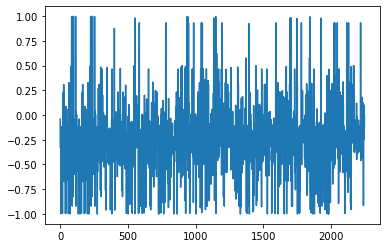

In [8]:
plt.plot(file['score'])

参考
https://zatsugaku-engineer.com/python/negaposi/
https://qiita.com/ChabesuB/items/e451f9a3882433658b27